In [18]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

## 1. ETL: Loading the dataset

**Note**: I chose Nepali

In [3]:
import pandas as pd

In [4]:
data_raw = pd.read_excel("english-nepali.xlsx")

In [5]:
data_raw 

,english_sent,nepali_sent
0,"It happened after the death of Saul, when Davi...",दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...
1,"it happened on the third day, that behold, a m...",तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...
2,"David said to him, ""Where do you come from?"" H...","दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ..."
3,"David said to him, ""How did it go? Please tell...","दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “..."
4,"David said to the young man who told him, ""How...","दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ..."
...,...,...
151932,(b) \tReporting will be regularised by develop...,(ख) आयोजनाहरुको प्रकृति अनुरुप अनुगमन तथा मूल्...
151933,"(c) \tImpartial on-going, mid -term and impact...",(ग) उपयुक्तताअनुरुप आयोजनाहरुको निष्पक्ष अद्या...
151934,(d) \tThe monitoring and evaluation data will ...,(घ) क्रमिक रुपमा अनुगमन तथा मूल्याङ्कन तथ्याङ्...
151935,(e) \tAppropriate rules and regulations will b...,्(ँङ) केन्द्रीय अनुगमन तथा मूल्याङ्कन व्यवस्था...


In [6]:
data_raw.dropna(inplace=True)
data_raw.tail()

,english_sent,nepali_sent
151932,(b) \tReporting will be regularised by develop...,(ख) आयोजनाहरुको प्रकृति अनुरुप अनुगमन तथा मूल्...
151933,"(c) \tImpartial on-going, mid -term and impact...",(ग) उपयुक्तताअनुरुप आयोजनाहरुको निष्पक्ष अद्या...
151934,(d) \tThe monitoring and evaluation data will ...,(घ) क्रमिक रुपमा अनुगमन तथा मूल्याङ्कन तथ्याङ्...
151935,(e) \tAppropriate rules and regulations will b...,्(ँङ) केन्द्रीय अनुगमन तथा मूल्याङ्कन व्यवस्था...
151936,(f) \tThe concepts of management by result and...,(च) अनुगमन तथा मूल्याङ्कनको परिपाटीलाई कर्मचार...


In [7]:
import re  
# Some sentences have leading (someCharacter) for example: (b) and (ख) in (b) \tReporting will be regularised by develop...	(ख) आयोजनाहरुको प्रकृति अनुरुप अनुगमन तथा मूल्..
def clean_text(text):
    if isinstance(text, str):
        return re.sub(r'^\([^)]+\)\s*', '', text).strip()  #Remove (someCharacter) and leading spaces
    return text

In [8]:
data_raw["english_sent"] = data_raw["english_sent"].apply(clean_text)
data_raw["nepali_sent"] = data_raw["nepali_sent"].apply(clean_text)

In [9]:
data_raw.head()

,english_sent,nepali_sent
0,"It happened after the death of Saul, when Davi...",दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...
1,"it happened on the third day, that behold, a m...",तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...
2,"David said to him, ""Where do you come from?"" H...","दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ..."
3,"David said to him, ""How did it go? Please tell...","दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “..."
4,"David said to the young man who told him, ""How...","दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ..."


In [10]:
#Will use lower sample to increase trainning speed
data_raw = data_raw.sample(n=30000, random_state=42)

In [11]:
data_raw.shape

(30000, 2)

## 2. EDA - simple investigation

In [12]:
#Converiting to list
dataset = data_raw.values.tolist()
dataset_size = len(dataset)

In [13]:
random.shuffle(dataset)

In [14]:
# Spliting: 90% Train, 10% Test
train_data_set_size = int(dataset_size * 0.9)
train_dataset = dataset[:train_data_set_size]
test = dataset[train_data_set_size:]

In [15]:
# Splitting train set: 90% Train, 10% Validation
train_size = int(train_data_set_size * 0.9)
train = train_dataset[:train_size]
val = train_dataset[train_size:]

In [16]:
len(train), len(test), len(val)

(24300, 3000, 2700)

## 3. Preprocessing

In [19]:
import spacy
from torchtext.data.utils import get_tokenizer
from indicnlp.tokenize import indic_tokenize

In [18]:
# Define source (English) and target (Nepali) languages
SRC_LANGUAGE = 'en'  # English as Source
TRG_LANGUAGE = 'np'  # Nepali as Target

In [19]:
# Place-holders for tokenization & vocabulary
token_transform = {}
vocab_transform = {}

In [20]:
# English Tokenizer (Using Spacy)
spacy_en = spacy.load("en_core_web_sm")
token_transform[SRC_LANGUAGE] = lambda text: [tok.text for tok in spacy_en(text)]

In [21]:
#Nepali Tokenize using indicnlp
def nepali_tokenizer(text):
    return indic_tokenize.trivial_tokenize(text, lang='ne')

token_transform[TRG_LANGUAGE] = nepali_tokenizer

In [22]:
print("Sentence: ", train[0][0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](train[0][0]))

Sentence:  Please type a valid command line...
Tokenization:  ['Please', 'type', 'a', 'valid', 'command', 'line', '...']


In [23]:
print("Sentence: ", train[0][1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](train[0][1]))

Sentence:  कृपया चल नाम प्रविष्ट गर्नुहोस् ।
Tokenization:  ['कृपया', 'चल', 'नाम', 'प्रविष्ट', 'गर्नुहोस्', '।']


In [24]:
# Function to Tockenize output
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]])

In [25]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [26]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [27]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'cat', 'baby'])

[269, 12485, 2969]

In [28]:
#see some example
vocab_transform[TRG_LANGUAGE](['दिनमा', 'दाऊदले', 'उपयुक्तताअनुरुप'])

[764, 588, 0]

In [29]:
#we can reverse its English....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()
# #print 1816, for example
mapping[400]

'save'

In [30]:
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [31]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import multiprocessing as mp
BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    global func
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    import pickle
        
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [32]:
text_transform

{'en': <function __main__.func(txt_input)>,
 'np': <function __main__.func(txt_input)>}

## Create train, val, and test dataloaders

In [33]:
train_loader = DataLoader(train, batch_size=16, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=16, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test, batch_size=16, shuffle=False, collate_fn=collate_batch)

In [34]:
for en, _, ne in train_loader:
    break

In [35]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Nepali shape: ", ne.shape)   # (batch_size, seq len)

English shape:  torch.Size([39, 16])
Nepali shape:  torch.Size([26, 16])


In [36]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

## 5. Design the model

In [49]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src: [src len, batch size]
        #src len: [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
        embedded, src_len.to("cpu"), enforce_sorted=False)
    
        packed_outputs, hidden = self.rnn(packed_embedded)
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #[src len, batch size, hid dim * num directions]
        
        forward  = hidden[-2, :, :]  #[batch size, hid dim]
        backward = hidden[-1, :, :]  #[batch size, hid dim]
        
        hidden = torch.tanh(self.fc(torch.cat((forward, backward), dim = 1))) 
        
        return outputs, hidden

In [51]:
class Attention(nn.Module):
    def __init__(self, hid_dim, variants):
        super().__init__()
        self.variants = variants
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)      #[batch size, src len, hid dim * 2]

        if self.variants == 'additive': #work
            hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)   #batch size, src len, hid dim]
            energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))  #[batch size, src len, hid dim]
            attention = self.v(energy).squeeze(2) # [batch size, src len]

        elif self.variants == 'multiplicative':
            wh = self.W(hidden).unsqueeze(1).repeat(1, 1, 2)       # wh = [batch size, 1, hid dim*2]
            energy = torch.bmm(wh, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)
            
        elif self.variants == 'general':
            hidden = hidden.unsqueeze(1).repeat(1, 1, 2)      # [batch size, 1, hid dim*2]
            energy = torch.bmm(hidden, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)        #attention = [batch size, src len]

        attention = attention.masked_fill(mask, -1e10)       # attention = [batch size, src len]
        return F.softmax(attention, dim = 1)

In [39]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        
        # input: [batch size]
        #hidden: [batch size, hid dim]
        #encoder_outputs:[src len, batch size, hid dim * 2]
        #mask:[batch size, src len]
        
        input = input.unsqueeze(0)      # [1, batch size]
        
        embedded = self.dropout(self.embedding(input))          # [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)          #[batch size, src len]

        a = a.unsqueeze(1)                                        #[batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)         #[batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)                 #[batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)                      #[1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)             #[1, batch size, (hid dim * 2) + emb dim]
        
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))      #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [40]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        
        mask = (src == self.src_pad_idx).permute(1, 0) #[batch size, src len]
        return mask

        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src:[src len, batch size]
        #src len:[batch size]
        #trg: [trg len, batch size]
        
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim #define in decoder
        
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        
        encoder_outputs, hidden = self.encoder(src, src_len)
        input_ = trg[0,:]  
        mask = self.create_mask(src)
        
        #for each of trg word
        for t in range(1, trg_len):

            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output:[batch size, output_dim]
            #hidden:[batch size, hid_dim]
            #attention:[batch size, src len]
            
            #append the results to outputs and attentions
            outputs[t] = output
            attentions[t] = attention
            
            top1 = output.argmax(1)  #find the maximum index of dimension 1, which is output_dim
            
           
            teacher_force_or_not = random.random() < teacher_forcing_ratio
            input_ = trg[t] if teacher_force_or_not else top1
            
        return outputs, attentions

## 6. Training

In [41]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [42]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 16  
hid_dim     = 32  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants='additive')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model_additive = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model_additive.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(14420, 16)
    (rnn): GRU(16, 32, bidirectional=True)
    (fc): Linear(in_features=64, out_features=32, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=32, out_features=1, bias=False)
      (W): Linear(in_features=32, out_features=32, bias=True)
      (U): Linear(in_features=64, out_features=32, bias=True)
    )
    (embedding): Embedding(20950, 16)
    (gru): GRU(80, 32)
    (fc): Linear(in_features=112, out_features=20950, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [43]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model_additive)

230720
  1536
  3072
    96
    96
  1536
  3072
    96
    96
  2048
    32
    32
  1024
    32
  2048
    32
335200
  7680
  3072
    96
    96
2346400
 20950
______
2959062


In [44]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model_additive.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

In [45]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [46]:
def evaluate(model, loader, criterion, loader_length):
        
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [47]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [50]:
#Train for Additive Model


best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model_additive, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_additive, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 5m 30s
	Train Loss: 2.021 | Train PPL:   7.542
	 Val. Loss: 1.942 |  Val. PPL:   6.970
Epoch: 02 | Time: 6m 16s
	Train Loss: 1.552 | Train PPL:   4.720
	 Val. Loss: 1.806 |  Val. PPL:   6.089
Epoch: 03 | Time: 6m 15s
	Train Loss: 1.330 | Train PPL:   3.780
	 Val. Loss: 1.712 |  Val. PPL:   5.540
Epoch: 04 | Time: 6m 23s
	Train Loss: 1.201 | Train PPL:   3.324
	 Val. Loss: 1.704 |  Val. PPL:   5.495
Epoch: 05 | Time: 6m 23s
	Train Loss: 1.122 | Train PPL:   3.071
	 Val. Loss: 1.687 |  Val. PPL:   5.401


Text(0, 0.5, 'loss')

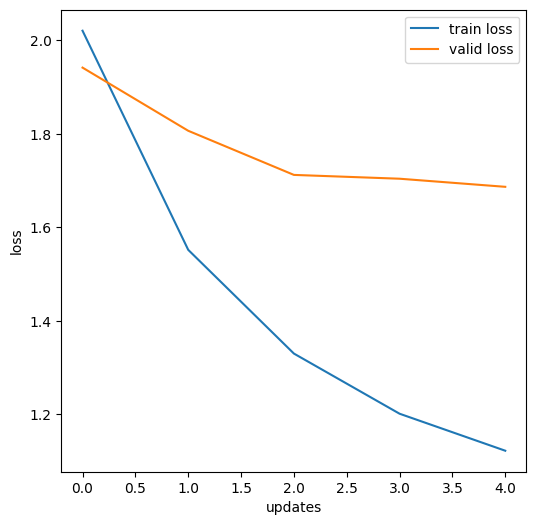

In [54]:
#Plotting Train Loss for Additive

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [62]:
#Lets try General
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 128  
hid_dim     = 256  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants='general')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model_general = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model_general.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(9053, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=256, out_features=1, bias=False)
      (W): Linear(in_features=256, out_features=256, bias=True)
      (U): Linear(in_features=512, out_features=256, bias=True)
    )
    (embedding): Embedding(8816, 128)
    (gru): GRU(640, 256)
    (fc): Linear(in_features=896, out_features=8816, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
#Train for General Model


best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model_general, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_general, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Text(0, 0.5, 'loss')

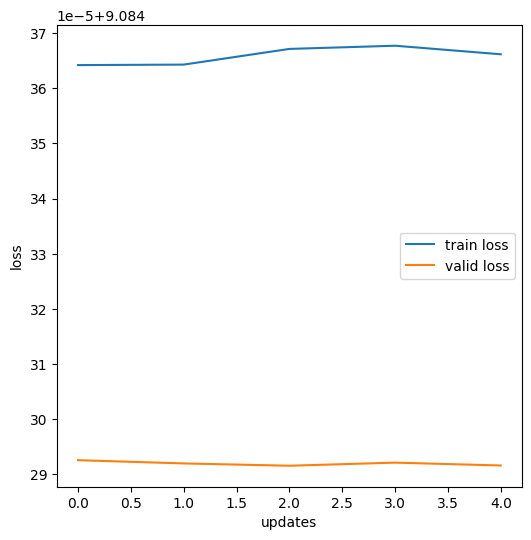

In [61]:
#Plotting Train Loss for General

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [64]:
#Lets try Multiplicative
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 128  
hid_dim     = 256  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants='multiplicative')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model_multiplicative = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(9053, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=256, out_features=1, bias=False)
      (W): Linear(in_features=256, out_features=256, bias=True)
      (U): Linear(in_features=512, out_features=256, bias=True)
    )
    (embedding): Embedding(8816, 128)
    (gru): GRU(640, 256)
    (fc): Linear(in_features=896, out_features=8816, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [65]:
#Train for Multiplicative Model


best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model_multiplicative, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_multiplicative, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 5m 50s
	Train Loss: 9.084 | Train PPL: 8815.828
	 Val. Loss: 9.084 |  Val. PPL: 8816.048
Epoch: 02 | Time: 5m 49s
	Train Loss: 9.084 | Train PPL: 8815.834
	 Val. Loss: 9.084 |  Val. PPL: 8816.043
Epoch: 03 | Time: 6m 6s
	Train Loss: 9.084 | Train PPL: 8815.818
	 Val. Loss: 9.084 |  Val. PPL: 8816.042


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

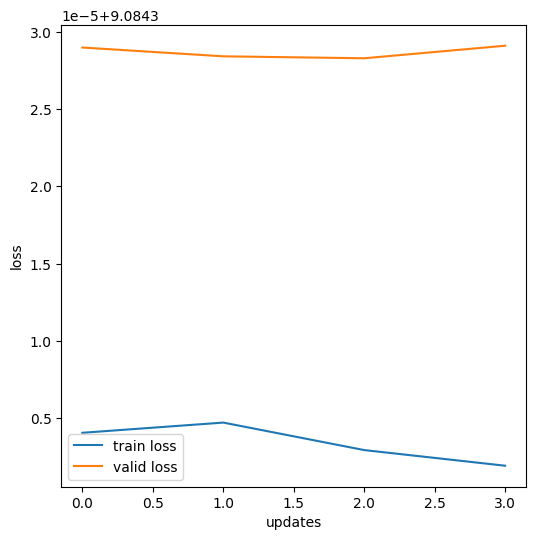

In [66]:
#Plotting Train Loss for General

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')